In [1]:
# Mount Google Colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd '/content/gdrive/My Drive/Masters_Thesis'


Mounted at /content/gdrive
/content/gdrive/My Drive/Masters_Thesis


In [2]:
!pip install stepmix # library used to build LCA model

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from stepmix.stepmix import StepMix

from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

np.random.seed(42)

In [4]:
# Provide the filename of your Excel file
file_name = 'uu_preprocessed.xlsx'

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_name)

In [5]:
work_values = df[df['maingroup'] == 'tests.workvalues.title']
len(work_values.question_id.unique())

# Above gives: array(['Prestaties leveren', 'Arbeidsvoorwaarden', 'Erkenning',
#       'Collegialiteit', 'Ondersteuning', 'Onafhankelijkheid'],
#      dtype=object)

#Is the same as:
#array(['Deliver performance', 'Terms of employment', 'Recognition',
#       'Collegiality', 'Support', 'Independence'],
#      dtype=object)

20

#Splitting data into answers for work_values test

In [6]:
# Specify the column names want to keep
columns_to_keep = ['question_id', 'maingroup', 'level1subgroup']

# Subset the data using the specified columns
wrk_v = work_values.loc[:, columns_to_keep]

wrk_v = wrk_v.drop(['maingroup'], axis=1)
qs = wrk_v.drop_duplicates(subset='question_id')
qs = qs.sort_values('level1subgroup')
qs

# Create the 'short_name' column
qs['short_name'] = ''

# same process as outlined in personality test
count_dp = 1
count_toe = 1
count_r2 = 1
count_c2 = 1
count_s2 = 1
count_i2 = 1

for index, row in qs.iterrows():
    if row['level1subgroup'] == 'Prestaties leveren':
        qs.at[index, 'short_name'] = f'drp{count_dp}'
        count_dp += 1

    elif row['level1subgroup'] == 'Arbeidsvoorwaarden':
        qs.at[index, 'short_name'] = f'toe{count_toe}'
        count_toe += 1

    elif row['level1subgroup'] == 'Erkenning':
        qs.at[index, 'short_name'] = f'rec{count_r2}'
        count_r2 += 1

    elif row['level1subgroup'] == 'Collegialiteit':
        qs.at[index, 'short_name'] = f'col{count_c2}'
        count_c2 += 1

    elif row['level1subgroup'] == 'Ondersteuning':
        qs.at[index, 'short_name'] = f'sup{count_s2}'
        count_s2 += 1
    else:
        qs.at[index, 'short_name'] = f'ind{count_i2}'
        count_i2 += 1

qs

,question_id,level1subgroup,short_name
110,2336,Arbeidsvoorwaarden,toe1
111,2351,Arbeidsvoorwaarden,toe2
112,2344,Arbeidsvoorwaarden,toe3
113,2354,Arbeidsvoorwaarden,toe4
114,2337,Arbeidsvoorwaarden,toe5
115,2352,Arbeidsvoorwaarden,toe6
121,2338,Collegialiteit,col1
119,2350,Collegialiteit,col2
120,2349,Collegialiteit,col3
117,2339,Erkenning,rec1


In [7]:
n_qs = qs.drop(['level1subgroup'], axis=1)

# merging (left join) studeies to orginal dataframe
new_qs = pd.merge(work_values, n_qs, on='question_id', how='left')
new_qs.head(3)

,dossier_id,question_id,answer,label,maingroup,maingroup_id,level1subgroup,level1subgroup_id,faculty,short_name
0,1532,2347,0.4,Dat ik kan doen waar ik goed in ben,tests.workvalues.title,508.0,Prestaties leveren,509,Faculteit Betawetenschappen,drp2
1,1532,2355,0.6,Dat ik het gevoel heb dat ik iets bereik met w...,tests.workvalues.title,508.0,Prestaties leveren,509,Faculteit Betawetenschappen,drp1
2,1532,2336,0.2,Dat ik de hele dag bezig kan zijn,tests.workvalues.title,508.0,Arbeidsvoorwaarden,510,Faculteit Betawetenschappen,toe1


In [8]:
qs_data = pd.pivot_table(new_qs, values='answer', index='dossier_id', columns='short_name')

# Reset index
qs_data = qs_data.reset_index()
qs_data = qs_data.rename_axis(None, axis=1)
# Remove NAN values
qs_data.replace('', np.nan, inplace=True)
qs_data = qs_data.dropna()
qs_data

,dossier_id,col1,col2,col3,drp1,drp2,ind1,ind2,ind3,rec1,...,rec3,sup1,sup2,sup3,toe1,toe2,toe3,toe4,toe5,toe6
0,1532,0.6,0.8,0.8,0.6,0.4,0.4,0.0,0.4,0.2,...,0.4,0.6,0.6,0.8,0.2,0.0,0.0,0.2,0.0,0.8
1,2112,0.8,0.6,0.2,0.6,0.8,0.6,0.4,0.8,0.4,...,0.8,0.0,0.4,0.4,0.0,0.2,0.0,0.0,0.2,0.6
2,30690,0.6,0.4,0.4,0.8,0.8,0.6,0.6,0.8,0.8,...,0.6,0.8,0.8,0.6,0.8,0.8,0.4,0.6,0.6,0.6
3,42388,0.0,0.6,0.6,0.8,0.6,0.8,0.8,0.8,0.2,...,0.6,0.4,0.4,0.4,0.2,0.4,0.0,0.0,0.2,0.2
4,42415,0.0,0.2,0.4,0.6,0.8,0.6,0.4,0.8,0.6,...,0.4,0.8,0.6,0.0,0.0,0.2,0.2,0.2,0.4,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,91894,0.8,0.8,0.4,0.8,0.4,0.6,0.6,0.6,0.6,...,0.6,0.8,0.6,0.6,0.2,0.6,0.4,0.4,0.4,0.8
445,91908,0.8,0.8,0.6,0.8,0.8,0.6,0.4,0.6,0.0,...,0.6,0.6,0.8,0.4,0.8,0.6,0.0,0.6,0.6,0.6
446,91927,0.6,0.4,0.8,0.8,0.8,0.6,0.4,0.6,0.2,...,0.6,0.6,0.4,0.4,0.4,0.6,0.4,0.6,0.4,0.6
447,91928,0.6,0.8,0.4,0.8,0.8,0.8,0.8,0.6,0.4,...,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.8,0.6


No need to sort the columns (like done in personality test notebook)

In [9]:
model = qs_data.drop('dossier_id', axis=1)
model

# Collect data for LCA before possible K-Means manipulation
data_lca = model

In [10]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Creating X variable to use as to not effect the model data
X = model

# Range of cluster numbers to test
n_clusters_range = range(2, 10)
wcss = [] # For Elbow

# Dictionaries to store the metrics
metrics = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
    'n_clusters': []
}

# Loop over the cluster numbers and perform clustering
for i, n_clusters in enumerate(n_clusters_range):

    # Run hierarchical clustering using the ward linkage method
    ward_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ward_cluster.fit(X)

    #Extract the labels and linkage matrix
    ward_labels = ward_cluster.labels_
    linkage_matrix = ward_cluster.children_

    # Extract the cluster centroids from the linkage matrix
    centroids = []
    for j in range(n_clusters):
        indices = ward_labels == j
        centroid = X[indices].mean(axis=0)
        centroids.append(centroid)
    kmeans_cluster = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=0)
    kmeans_cluster.fit(X)
    cluster_labels = kmeans_cluster.labels_

    # Calculate the metrics for the current cluster assignment
    inertia = kmeans_cluster.inertia_
    silhouette = silhouette_score(X, kmeans_cluster.labels_)
    calinski_harabasz = calinski_harabasz_score(X, kmeans_cluster.labels_)
    davies_bouldin = davies_bouldin_score(X, kmeans_cluster.labels_)

    # Store the metrics in the dictionary
    metrics['silhouette'].append(silhouette)
    metrics['calinski_harabasz'].append(calinski_harabasz)
    metrics['davies_bouldin'].append(davies_bouldin)
    metrics['n_clusters'].append(n_clusters)
    wcss.append(kmeans_cluster.inertia_)

# Convert the metrics dictionary to dataframe
metrics_df = pd.DataFrame(metrics)

metrics_df

,silhouette,calinski_harabasz,davies_bouldin,n_clusters
0,0.231162,119.329249,1.867622,2
1,0.069998,73.671809,2.476830,3
2,0.157890,56.274576,2.251083,4
3,0.151696,48.208442,2.263401,5
4,0.078700,43.876872,2.613791,6
5,0.079536,39.709153,2.538739,7
6,0.077731,36.715675,2.474525,8
7,0.065236,33.989134,2.503967,9


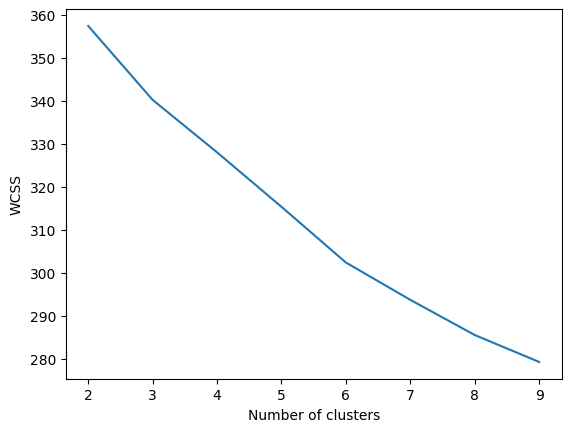

In [12]:
# Plot Elbow
plt.plot(n_clusters_range, wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

<Axes: xlabel='PC1', ylabel='PC2'>

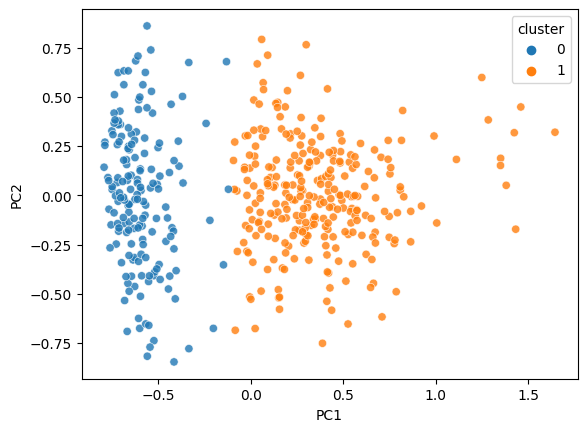

In [13]:
# Create Kmeans Cluster Model
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

seed = 1234 # Used for reproducibility

kmeans = KMeans(n_clusters=2, n_init = 10, random_state=seed)
k_fit = kmeans.fit(model)
centroids = kmeans.cluster_centers_
predictions = k_fit.labels_

# Develop 2 PCA components for visualizations
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(model),columns=['PC1','PC2'])

pca_data['cluster'] = pd.Categorical(predictions)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data, palette='tab10', alpha=0.8)

Exporting PCA data so can be put in a comparison plot with other tests (done so in the personality test cluster notebook)

In [ ]:
#pca_data.to_excel('before_work_v_clusters.xlsx', index=False) # to be used for comparison in personality notebook

#Latent Class Analysis

In [ ]:
from sklearn.model_selection import ParameterGrid
# Create LCA model
model = StepMix(n_components=3, measurement="categorical", verbose=1, random_state=123, n_init=10)

grid = {
    'n_components': [2, 3, 4, 5, 6, 7, 8, 9],
    'n_steps' : [1]
}

results = dict(param_n_steps=[], param_n_components=[], aic=[], bic=[])


# Same model and grid as above
for g in ParameterGrid(grid):
    model.set_params(**g)
    model.fit(data_lca)
    results['param_n_steps'].append(g['n_steps'])
    results['param_n_components'].append(g['n_components'])
    results['aic'].append(model.aic(data_lca))
    results['bic'].append(model.bic(data_lca))

# Save results to a dataframe
results = pd.DataFrame(results)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 25.64it/s, max_LL=-805, max_avg_LL=-1.82]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 21 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 33.38it/s, max_LL=-805, max_avg_LL=-1.82]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 21 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 35.33it/s, max_LL=-805, max_avg_LL=-1.82]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 21 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 33.90it/s, max_LL=-805, max_avg_LL=-1.82]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 21 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [00:01<00:00,  5.09it/s, max_LL=-793, max_avg_LL=-1.79]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 21 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [00:02<00:00,  4.15it/s, max_LL=-793, max_avg_LL=-1.79]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 21 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.0000 1.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [00:02<00:00,  4.31it/s, max_LL=-793, max_avg_LL=-1.79]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 21 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [00:01<00:00,  6.80it/s, max_LL=-785, max_avg_LL=-1.77]

MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 21 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000


In [ ]:
results # print LCA results

,param_n_steps,param_n_components,aic,bic
0,1,2,2011.307466,2834.114989
1,1,3,2213.307466,3449.565536
2,1,4,2415.307466,4065.016083
3,1,5,2617.307466,4680.466630
4,1,6,2796.075165,5272.684876
5,1,7,2998.075165,5888.135423
6,1,8,3200.075165,6503.585970
7,1,9,3385.739414,7102.700766
